In [3]:
import numpy as np
import time
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting



In [4]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/MyDrive/data.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_74.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_1379.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_60.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_2102.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_586.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_1423.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_1345.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_48.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_1351.jpg  
  inflating: /root/datasets/data/sample_train/Action_Adventure/Action_Adventure_1437.jpg  
  inflating: /root/datasets/data/sample_train/

In [6]:
# define training and test data directories
data_dir = '/root/datasets/data'

train_dir = os.path.join(data_dir, 'sample_train/')
val_dir = os.path.join(data_dir, 'sample_validation/')
test_dir = os.path.join(data_dir, 'sample_test/')

classes = ['Action_Adventure', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror_Thriller', 'Romance']



In [50]:
# load and transform data using ImageFolder

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor()])
# data_transform = transforms.Compose(
#     [transforms.CenterCrop(224), transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

Num training images:  13373
Num validation images:  2857
Num testing images:  2862


In [51]:
# define dataloader parameters
batch_size  = 64
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

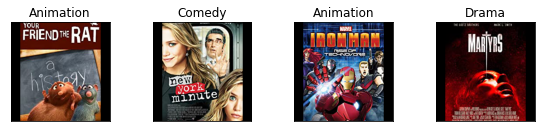

In [52]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Model Building (Convolutional Neural Network)

In [46]:
#Define a Convolutional Neural Network
class MovieNet(nn.Module):
    def __init__(self):
        super(MovieNet, self).__init__()
        self.name = "Movie"
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = x.view(-1, 16 * 53* 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

Training Code 

In [13]:
#Define the hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# defining the model
movie_net = MovieNet()

# defining the optimizer
#optimizer = optim.SGD(gesture_net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(movie_net.parameters(), lr = learning_rate)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = movie_net.cuda()
    criterion = criterion.cuda()

for param in movie_net.parameters():
    print(param.shape)

print(movie_net)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 44944])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([7, 84])
torch.Size([7])
MovieNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)


In [14]:
#Train the network
def train(net, batch_size=64, learning_rate=0.001, num_epochs=5):
  for epoch in range(num_epochs):  # loop over the dataset multiple times

      total_train_loss = 0.0
      total_train_err = 0.0
      total_epoch = 0
      correct = 0
      total = 0 
      
      # train_err = [num_epochs]
      # train_loss = [num_epochs]
      # val_err = [num_epochs]
      # val_loss = [num_epochs]

      train_err = np.zeros(num_epochs)
      train_loss = np.zeros(num_epochs)
      val_err = np.zeros(num_epochs)
      val_loss = np.zeros(num_epochs)

      start_time = time.time()
      for i, data in enumerate(train_loader, 0):
          total_train_loss = 0.0
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          #inputs, labels = (inputs).type(torch.FloatTensor), (labels)
          
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
            
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          total_train_err += (predicted != labels).sum().item()
          total_train_loss += loss.item()
          total_epoch += len(labels)
          if i % 1000 == 999:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {total_train_loss / 1000:.5f}')
            
      train_err[epoch] = float(total_train_err) / total_epoch
      train_loss[epoch] = float(total_train_loss) / (i+1)
      val_err[epoch], val_loss[epoch] = evaluate(movie_net, val_loader, criterion)
      print(("Epoch {}: Train err: {}, Train loss: {} |"+
                "Validation err: {}, Validation loss: {}").format(
                    epoch + 1,
                    train_err[epoch],
                    train_loss[epoch],
                    val_err[epoch],
                    val_loss[epoch]))
      # Save the current model (checkpoint) to a file
      model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
      torch.save(net.state_dict(), model_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [15]:
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels
    
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set."""

    total = 0

    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total_err += (predicted != labels).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (total)

    return err, loss

    
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [16]:
train(movie_net)

[1,   100] loss: 0.01684
[1,   200] loss: 0.01634
Epoch 1: Train err: 0.6447319225304718, Train loss: 0.008021149909097042 |Validation err: 0.6258312915645782, Validation loss: 0.024272177033295865
[2,   100] loss: 0.01444
[2,   200] loss: 0.01622
Epoch 2: Train err: 0.593584087340163, Train loss: 0.007770147049826298 |Validation err: 0.607280364018201, Validation loss: 0.023692373550142656
[3,   100] loss: 0.01555
[3,   200] loss: 0.01518
Epoch 3: Train err: 0.5300979585732446, Train loss: 0.0065761485168238 |Validation err: 0.6261813090654532, Validation loss: 0.025353468878935966
[4,   100] loss: 0.00958
[4,   200] loss: 0.00956
Epoch 4: Train err: 0.37927166679129587, Train loss: 0.00570495904347543 |Validation err: 0.6611830591529576, Validation loss: 0.027541042918044035
[5,   100] loss: 0.00450
[5,   200] loss: 0.00464
Epoch 5: Train err: 0.1704927839676961, Train loss: 0.0022713952657708713 |Validation err: 0.6727336366818341, Validation loss: 0.04034785828809034
Finished Train

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ['Action_Adventure', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror_Thriller', 'Romance']

# Visualize some training data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 7))
for idx in np.arange(7):
    ax = fig.add_subplot(2, 7, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
#Predition
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = movie_net(images)
_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for  j in range(7)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(7)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  Animation Horror_Thriller Comedy Drama Action_Adventure Comedy Drama


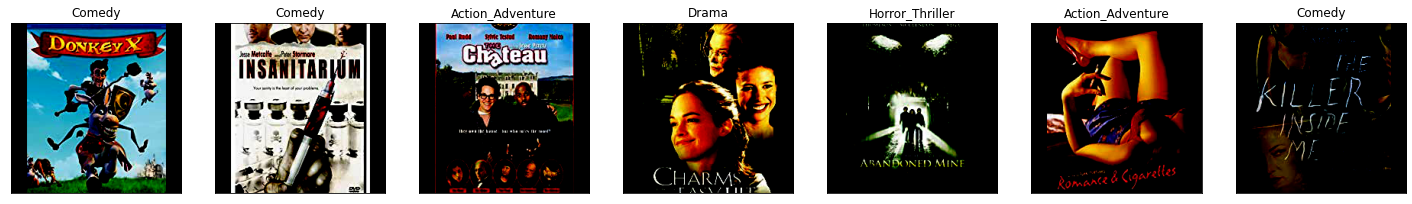

In [37]:
# Visualize some testing data

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 7))
for idx in np.arange(7):
    ax = fig.add_subplot(2, 7, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[predicted[idx]])
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(7)))


In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = movie_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 training images: {100 * correct // total} %')

Accuracy of the network on the 1000 training images: 94 %


In [31]:
#Show network performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = movie_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 1000 test images: {100.00 * correct // total} %')

Accuracy of the network on the 1000 test images: 33.0 %


In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = movie_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.5f} %')

Accuracy for class: Action_Adventure is 25.81345 %
Accuracy for class: Animation is 16.53543 %
Accuracy for class: Comedy is 57.46606 %
Accuracy for class: Documentary is 22.46377 %
Accuracy for class: Drama is 34.51996 %
Accuracy for class: Horror_Thriller is 14.39689 %
Accuracy for class: Romance is 0.00000 %


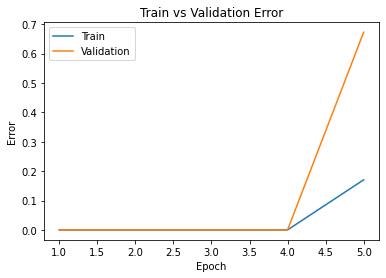

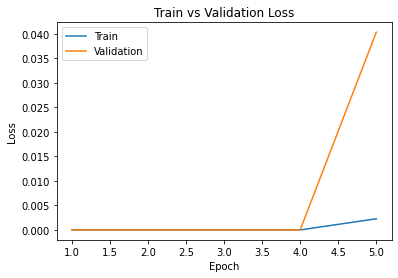

In [39]:
model_path = get_model_name("Movie", batch_size=batch_size, learning_rate=learning_rate, epoch=num_epochs-1)
plot_training_curve(model_path)

In [56]:
#Define the hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 5

# defining the model
movie_net = MovieNet()

# defining the optimizer
optimizer = optim.SGD(movie_net.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(movie_net.parameters(), lr = learning_rate)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = movie_net.cuda()
    criterion = criterion.cuda()

for param in movie_net.parameters():
    print(param.shape)

print(movie_net)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 44944])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([7, 84])
torch.Size([7])
MovieNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)


In [57]:
train(movie_net, batch_size, learning_rate, num_epochs);
# [1,   100] loss: 0.01636
# [1,   200] loss: 0.01653
# Epoch 1: Train err: 0.6792791445449787, Train loss: 0.007718723926817972 |Validation err: 0.6489324466223311, Validation loss: 0.02588834143369232
# [2,   100] loss: 0.01534
# [2,   200] loss: 0.01607
# Epoch 2: Train err: 0.6498167950347715, Train loss: 0.006815769455649636 |Validation err: 0.6398319915995799, Validation loss: 0.024905882183805312
# [3,   100] loss: 0.01587
# [3,   200] loss: 0.01510
# Epoch 3: Train err: 0.6425633739624617, Train loss: 0.008400173848895935 |Validation err: 0.6303815190759537, Validation loss: 0.02447312567506923
# [4,   100] loss: 0.01577
# [4,   200] loss: 0.01469
# Epoch 4: Train err: 0.6288790847229492, Train loss: 0.0069232106779180645 |Validation err: 0.6765838291914595, Validation loss: 0.024926471968902172
# [5,   100] loss: 0.01436
# [5,   200] loss: 0.01500
# Epoch 5: Train err: 0.614895685336125, Train loss: 0.006356961419137471 |Validation err: 0.6387819390969548, Validation loss: 0.02433193255689205
# Finished Training
# Total time elapsed: 278.33 seconds

[1,   100] loss: 0.01636
[1,   200] loss: 0.01653
Epoch 1: Train err: 0.6792791445449787, Train loss: 0.007718723926817972 |Validation err: 0.6489324466223311, Validation loss: 0.02588834143369232
[2,   100] loss: 0.01534
[2,   200] loss: 0.01607
Epoch 2: Train err: 0.6498167950347715, Train loss: 0.006815769455649636 |Validation err: 0.6398319915995799, Validation loss: 0.024905882183805312
[3,   100] loss: 0.01587
[3,   200] loss: 0.01510
Epoch 3: Train err: 0.6425633739624617, Train loss: 0.008400173848895935 |Validation err: 0.6303815190759537, Validation loss: 0.02447312567506923
[4,   100] loss: 0.01577
[4,   200] loss: 0.01469
Epoch 4: Train err: 0.6288790847229492, Train loss: 0.0069232106779180645 |Validation err: 0.6765838291914595, Validation loss: 0.024926471968902172
[5,   100] loss: 0.01436
[5,   200] loss: 0.01500
Epoch 5: Train err: 0.614895685336125, Train loss: 0.006356961419137471 |Validation err: 0.6387819390969548, Validation loss: 0.02433193255689205
Finished Trai

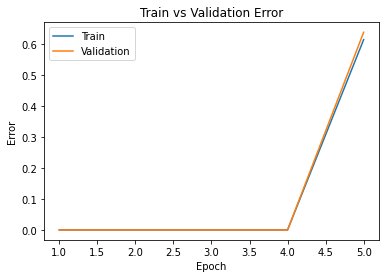

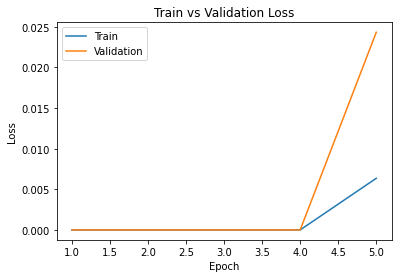

In [99]:
model_path = get_model_name("Movie", batch_size=batch_size, learning_rate=learning_rate, epoch=num_epochs-1)
plot_training_curve(model_path)

In [98]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = movie_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 training images: {100 * correct // total} %')

Accuracy of the network on the 1000 training images: 40 %


In [58]:
#Show network performs on the whole dataset.

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = movie_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 1000 test images: {100.00 * correct // total} %')

Accuracy of the network on the 1000 test images: 38.0 %


In [59]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = movie_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.5f} %')

Accuracy for class: Action_Adventure is 4.77223 %
Accuracy for class: Animation is 2.36220 %
Accuracy for class: Comedy is 40.87481 %
Accuracy for class: Documentary is 0.00000 %
Accuracy for class: Drama is 86.40777 %
Accuracy for class: Horror_Thriller is 2.33463 %
Accuracy for class: Romance is 0.00000 %


GroundTruth:  Comedy Comedy Comedy Animation Action_Adventure Comedy Comedy
Predicted:  Comedy Drama Comedy Comedy Drama Comedy Drama
GroundTruth:  Comedy Comedy Comedy Animation Action_Adventure Comedy Comedy


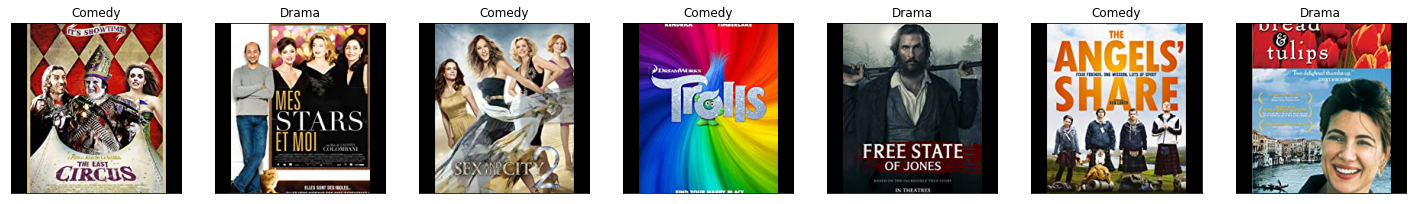

In [75]:
#Predition
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = movie_net(images)
_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for  j in range(7)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(7)))
# Visualize some testing data

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 7))
for idx in np.arange(7):
    ax = fig.add_subplot(2, 7, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[predicted[idx]])
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(7)))


In [97]:
#Confusion Matrix
#Predition
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = movie_net(images)
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for  j in range(64)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(64)))

# Importing the dependancies
from sklearn import metrics
# Predicted values
classes_pre = []
classes_act = []
for j in range(64):
  classes_pre.append(classes[predicted[j]])
  classes_act.append(classes[labels[j]])
# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.


print(metrics.confusion_matrix(classes_act,classes_pre, labels = classes))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(classes_act,classes_pre, labels = classes))

GroundTruth:  Documentary Documentary Drama Action_Adventure Comedy Drama Drama Documentary Drama Action_Adventure Comedy Action_Adventure Documentary Comedy Comedy Drama Drama Animation Drama Documentary Action_Adventure Drama Drama Comedy Horror_Thriller Horror_Thriller Documentary Documentary Horror_Thriller Horror_Thriller Drama Documentary Documentary Animation Horror_Thriller Comedy Comedy Comedy Horror_Thriller Drama Drama Comedy Drama Documentary Action_Adventure Comedy Horror_Thriller Documentary Comedy Horror_Thriller Comedy Drama Drama Action_Adventure Horror_Thriller Drama Action_Adventure Documentary Documentary Drama Action_Adventure Comedy Comedy Drama
Predicted:  Drama Drama Drama Drama Drama Drama Drama Comedy Drama Drama Drama Comedy Drama Comedy Comedy Drama Drama Drama Drama Drama Drama Drama Drama Drama Drama Action_Adventure Drama Drama Drama Drama Drama Drama Action_Adventure Drama Drama Drama Comedy Drama Drama Drama Drama Comedy Drama Drama Drama Drama Drama Dr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1